
# Sistema de Recomendación de Películas y Series de Netflix
## Luis Ivan Marquez Azuara - 220401
## 9a IDGS

### Importacion librerías



In [49]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel



### Carga y exploracion del dataset

In [50]:
netflix_dataset=pd.read_csv(r'netflix_dataset.csv')
netflix_dataset.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [51]:
netflix_dataset.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7281 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [52]:
netflix_dataset.describe()


,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


In [53]:
netflix_dataset.isnull().sum()


show_id            0
type               0
title              0
director        2389
cast             718
country          506
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [54]:
netflix_dataset['type'].value_counts()

type
Movie      5377
TV Show    2410
Name: count, dtype: int64

#### Cantidad de series 

In [55]:
netflix_dataset[netflix_dataset['type'] == 'TV Show'].shape[0]

2410

#### Cantidad de peliculas

In [56]:
netflix_dataset[netflix_dataset['type'] == 'Movie'].shape[0]


5377

#### Cantidad de titulos

In [57]:
netflix_dataset['title'].nunique()


7787

#### Tipo de contenido graficado

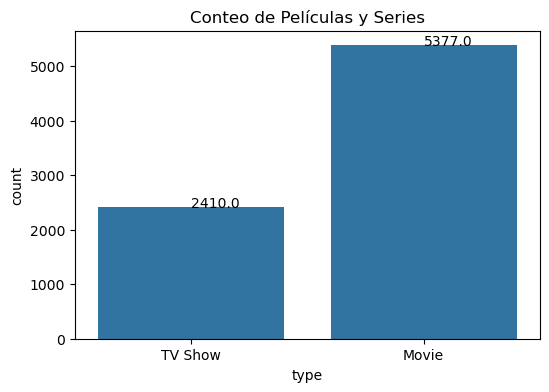

In [58]:

plt.figure(figsize=(6,4))
ax = sns.countplot(x='type', data=netflix_dataset)
plt.title("Conteo de Películas y Series")
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height))
plt.show()

#### Mapa de calor

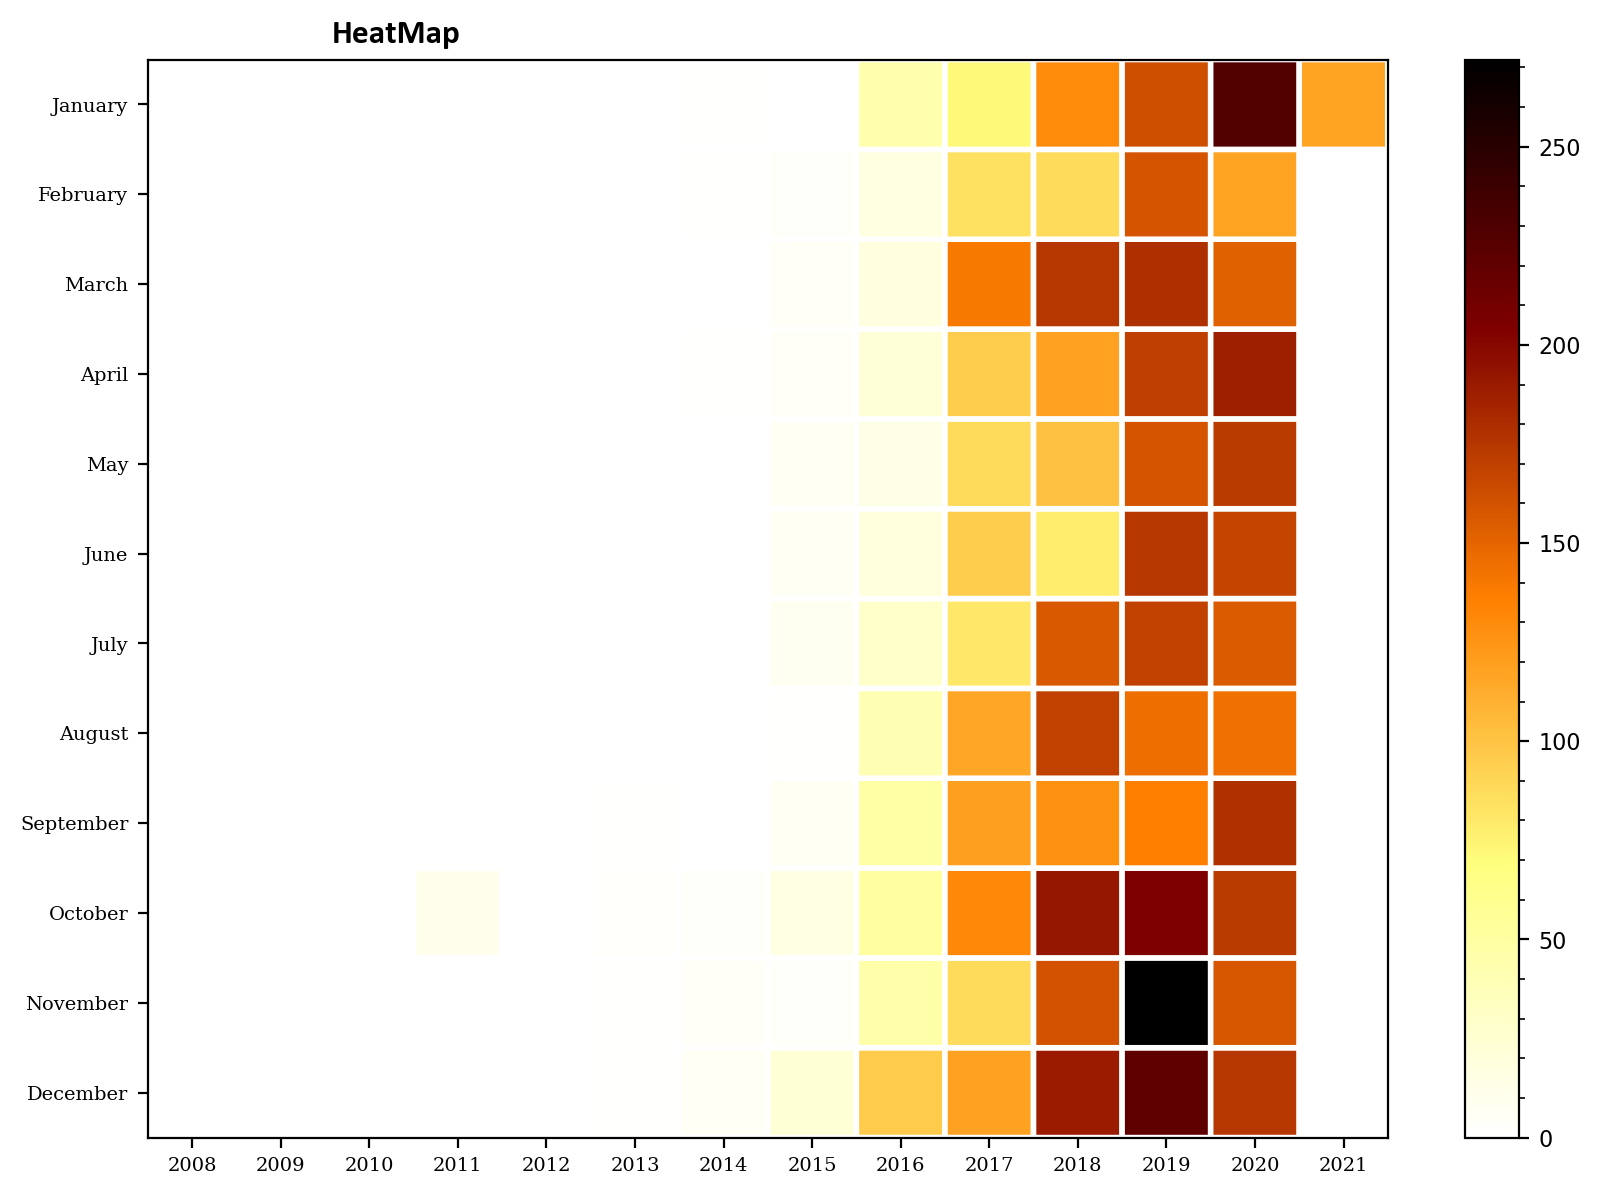

In [59]:
netflix_date['year'] = netflix_date['date_added'].apply(lambda x: str(x).split(', ')[-1])
netflix_date['month'] = netflix_date['date_added'].apply(lambda x: str(x).lstrip().split(' ')[0])

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December'][::-1]

df = netflix_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T

plt.figure(figsize=(10, 7), dpi=200)
plt.pcolor(df, cmap='afmhot_r', edgecolors='white', linewidths=2)  # heatmap estilo "tabla"
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=7, fontfamily='serif')

plt.title('HeatMap', 
          fontsize=12, fontfamily='calibri', fontweight='bold', position=(0.20, 1.02))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8)
cbar.ax.minorticks_on()
plt.show()

#### Grafica clasificacion de contenidos

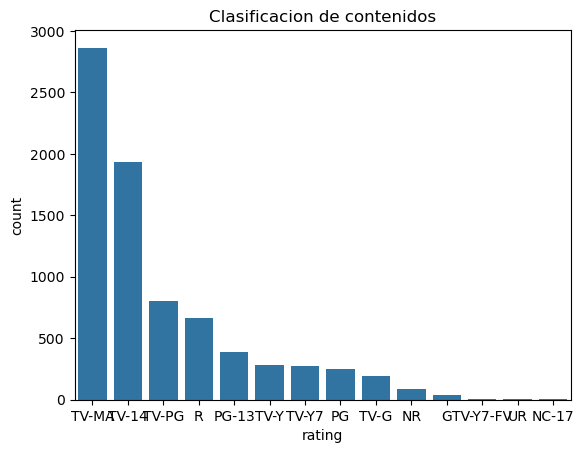

In [60]:
ax = sns.countplot(x='rating', data=netflix_dataset, order=netflix_dataset['rating'].value_counts().index)
plt.title("Clasificacion de contenidos")
plt.show()


#### Dataset IMdB

In [61]:
imdb_ratings = pd.read_csv('IMDb ratings.csv', usecols=['weighted_average_vote'])
imdb_titles = pd.read_csv('IMDb movies.csv', usecols=['title', 'year', 'genre'], low_memory=False)


ratings = pd.DataFrame({
    'Title': imdb_titles.title,
    'Release Year': imdb_titles.year,
    'Rating': imdb_ratings.weighted_average_vote,
    'Genre': imdb_titles.genre
})

ratings.drop_duplicates(subset=['Title','Release Year','Rating'], inplace=True)
ratings.shape


(85852, 4)

#### Unir con netflix

In [62]:
ratings.dropna()
joint_data=ratings.merge(netflix_dataset,left_on='Title',right_on='title',how='inner')
joint_data=joint_data.sort_values(by='Rating', ascending=False)

#### Limitar a 10 mejor evaluadas

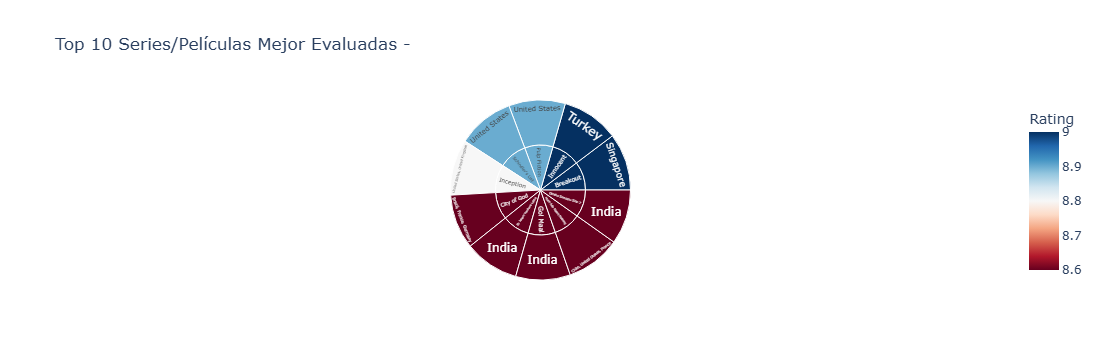

In [68]:
import plotly.express as px
top_rated = joint_data[['title', 'country', 'Rating']].dropna().head(10)
fig = px.sunburst(
    top_rated,
    path=['title', 'country'],
    values='Rating',
    color='Rating',
    color_continuous_scale='RdBu',
    title='Top 10 Series/Películas Mejor Evaluadas - '
)
fig.show()

#### Paises que mas generan contenido

In [69]:
contenidos_por_pais = netflix_dataset['country'].value_counts().dropna().head(11)
contenidos_por_pais_df = contenidos_por_pais.reset_index()
contenidos_por_pais_df.columns = ['País', 'Cantidad']
print(contenidos_por_pais_df)


              País  Cantidad
0    United States      2555
1            India       923
2   United Kingdom       397
3            Japan       226
4      South Korea       183
5           Canada       177
6            Spain       134
7           France       115
8            Egypt       101
9           Turkey       100
10          Mexico       100


#### Lanzamientos por año

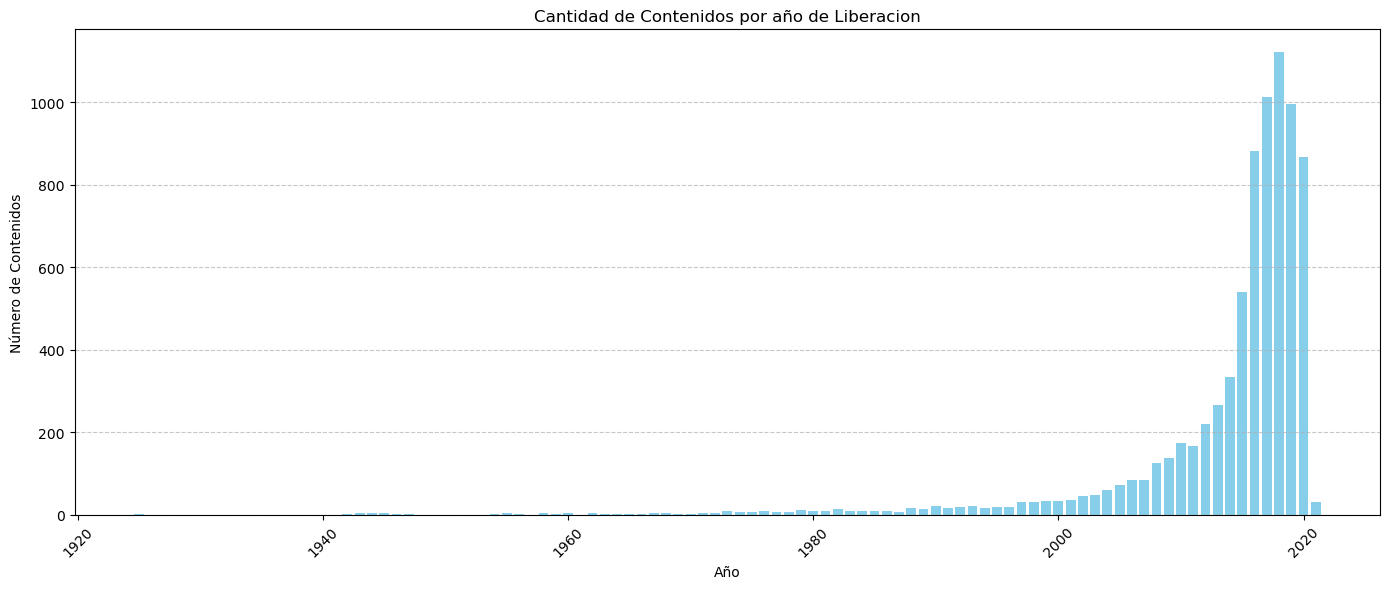

In [71]:
contenido_por_anio = netflix_dataset['release_year'].value_counts().sort_index()

plt.figure(figsize=(14,6))
plt.bar(contenido_por_anio.index, contenido_por_anio.values, color='skyblue')
plt.title("Cantidad de Contenidos por año de Liberacion")
plt.xlabel("Año")
plt.ylabel("Número de Contenidos")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Analisis de peliculas 

In [72]:
# filtro de peliculas
peliculas = netflix_dataset[netflix_dataset['type'] == 'Movie'].dropna(subset=['country', 'duration'])


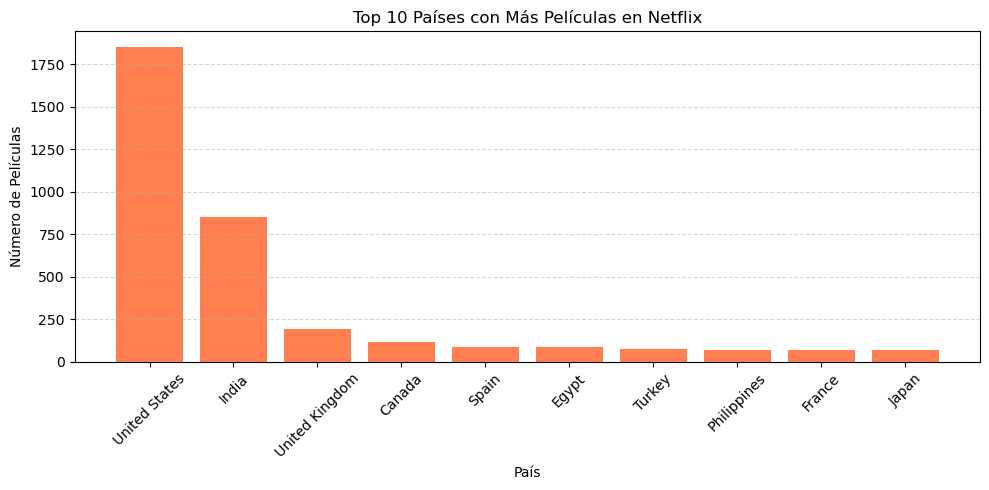

In [96]:
peliculas_por_pais = peliculas['country'].value_counts().head(10)
plt.figure(figsize=(10,5))
plt.bar(peliculas_por_pais.index, peliculas_por_pais.values, color='coral')
plt.title("Top 10 Países con Más Películas en Netflix")
plt.xlabel("País")
plt.ylabel("Número de Películas")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Grafico de duracion depeliculas

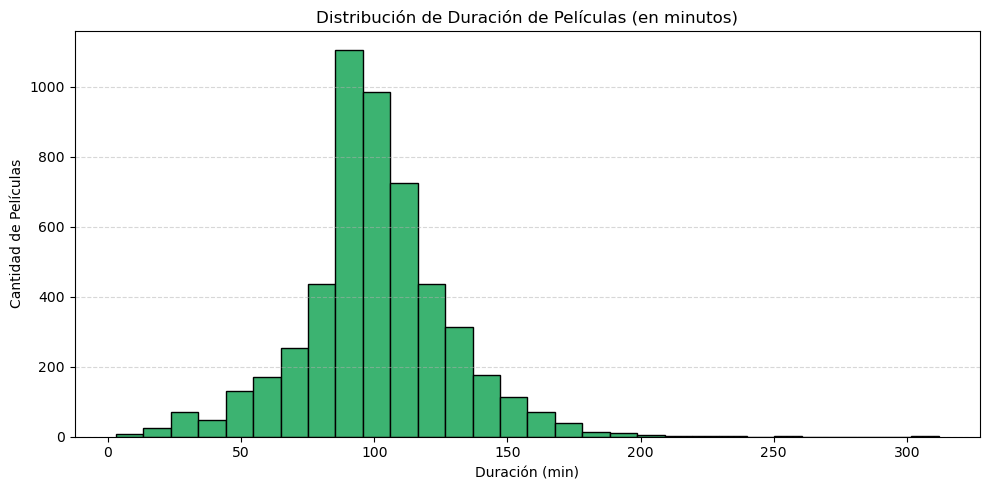

In [87]:
peliculas['duration_minutes'] = peliculas['duration'].str.extract(r'(\d+)').astype(float)
plt.figure(figsize=(10,5))
plt.hist(peliculas['duration_minutes'], bins=30, color='mediumseagreen', edgecolor='black')
plt.title("Distribución de Duración de Películas (en minutos)")
plt.xlabel("Duración (min)")
plt.ylabel("Cantidad de Películas")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Analisis de series de Tv

##### Gráfico de conteo por numero de temporadas (seasons) de las 20 más largas

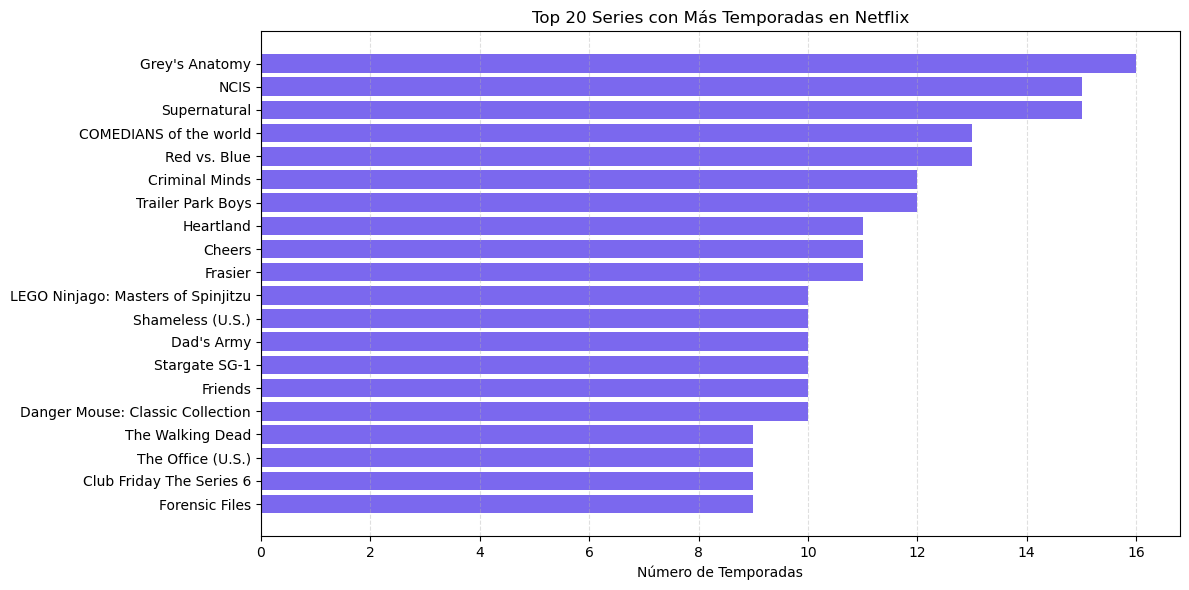

In [98]:
series = netflix_dataset[netflix_dataset['type'] == 'TV Show'].dropna(subset=['duration'])
series['num_seasons'] = series['duration'].str.extract(r'(\d+)').astype(int)
top20_series = series.sort_values(by='num_seasons', ascending=False).head(20)
plt.figure(figsize=(12, 6))
plt.barh(top20_series['title'], top20_series['num_seasons'], color='mediumslateblue')
plt.xlabel("Número de Temporadas")
plt.title("Top 20 Series con Más Temporadas en Netflix")
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()